In [2]:
import os, shutil
import torch
import glob
import json
import clip
from PIL import Image
import json
import sys
import spacy
from spacy.matcher import Matcher
import collections

from transformers import XCLIPProcessor, XCLIPModel, CLIPTokenizer
#evice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)

model, preprocess = clip.load("ViT-B/16", device=device)
# !python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

/home/aivn2023/anaconda3/envs/pytorch_1121_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


In [3]:
# with open("")
# path = "../data/AIC23_Track2_NL_Retrieval/data/train/S01/c003/img1/000032.jpg"
# image = Image.open(path)
# image = image.crop((1491, 413, 1491+393, 413+271))
# image.save("../data/AIC23_Track2_NL_Retrieval/data_aug/image.png")
# image = preprocess(image).unsqueeze(0).to(device)
# image_features = model.encode_image(image)
# print(image_features.shape)

# 1. Extract feature per tracks

Mỗi track lấy frame diện tích lớn nhất, extract feature bằng model CLIP

In [6]:
from tqdm import tqdm

dst_path = "../data/AIC23_Track2_NL_Retrieval/data/tracks"
shutil.rmtree(dst_path, ignore_errors=True)
os.makedirs(dst_path, exist_ok = True)

with open("../data/AIC23_Track2_NL_Retrieval/data/test-tracks.json", 'r') as f:
    tracks = json.load(f)
    # print(list(tracks.keys()))
    print(len(tracks))
    data = {}
    
    for uuid, track in tqdm(tracks.items()):
        #dst = f'{dst_path}/{uuid}'
        # os.makedirs(dst, exist_ok = True)
        # frames = track["frames"]
        # boxes  = track["boxes"]

        # max_area = min_area = 0
        # max_area_box = []
        # for i, box in enumerate(boxes):
        #     area = box[2]*box[3]

        #     # if i == 0:
        #     #     min_area = area
            
        #     # if area < min_area:
        #     #     min_area = area
        #     #     min_area_idx = i

        #     if area > max_area:
        #         max_area = area
        #         max_area_idx = i
        #         max_area_box = box

        # frame_path = frames[max_area_idx]
        # frame_path = "../data/AIC23_Track2_NL_Retrieval/data" + frame_path[1:]
        # frame = Image.open(frame_path)
        # box = boxes[max_area_idx]
        # fr = frame.crop((box[0], box[1], box[0]+box[2], box[1]+box[3]))

        # # Extract features
        # image = preprocess(fr).unsqueeze(0).to(device)
        # image_features = model.encode_image(image)
        # image_features = image_features.detach().cpu()
        # # print(image_features.shape)
        # image_features /= image_features.norm(dim=-1, keepdim=True)

        # Extract Text Features
        text = track['nl'][0]
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            name_object = chunk.text
            break
        
        text_input = clip.tokenize(f"a photo of {name_object}").to(device)
        text_features = model.encode_text(text_input).to(device)        

        data = {'text': text_features}
        torch.save(data, f"../data/AIC23_Track2_NL_Retrieval/data/clip_feats/{uuid}.pth")


#torch.save(data, "../data/AIC23_Track2_NL_Retrieval/data/test-tracks.pt")


184


100%|██████████| 184/184 [00:20<00:00,  8.98it/s]


In [45]:
print(len(list(tracks.keys())), len(frame_paths), len(choose_boxes), len(features))

184 184 184 184


In [46]:
data['features'] = torch.concat(features).shape

# 2. Extract object name from data

In [50]:
with open("../data/AIC23_Track2_NL_Retrieval/data/test-queries.json", 'r') as f:
    tracks = json.load(f)
    text_features = []
    for keys, val in tqdm(tracks.items(), total=len(list(tracks.keys()))):
        text = val['nl'][0]
        doc = nlp(text)
        for chunk in doc.noun_chunks:
            name_object = chunk.text
            break

        text_input = clip.tokenize(f"a photo of {name_object}").to(device)
        text_feats = model.encode_text(text_input).to(device)
        text_features.append(text_feats)
        

100%|██████████| 184/184 [00:07<00:00, 25.60it/s]


In [52]:
text_features = torch.concat(text_features)

In [53]:
text_features

torch.Size([184, 512])

In [67]:
def query_tracks(text, tracks, image_features, frame_paths, boxes, top_k=5):
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        name_object = chunk.text
        break

    text_input = clip.tokenize(f"a photo of {name_object}").to(device)
    text_features = model.encode_text(text_input).to(device)

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (text_features @ image_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(top_k)

    for i, (value, index) in enumerate(zip(values, indices)):

        track_id = tracks[index]
        #print(frame_path)
        print(track_id)
            

data = torch.load("../data/AIC23_Track2_NL_Retrieval/data/test-tracks.pt")
tracks = data["tracks"]
frame_paths = data["frames"]
boxes = data["boxes"]
features = torch.concat(data["features"])

text = "A dark gray sedan drives straight in the right lane on a curved road."
query_tracks(text, tracks, features, frame_paths, boxes, top_k=5)

bbf33554-4b4d-48ec-bdea-c67e1df0b799
b94fea86-ac81-4eb3-bef6-0196b755c8f9
4ce8ef25-0a7c-4f2f-819e-e314ef85ab5b
f311918e-5ff0-4424-aa7c-8b93bf6297a5
97730e60-859e-434a-9639-abe453e54e51


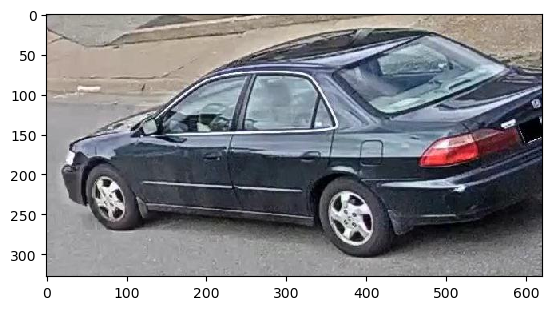

In [72]:
import matplotlib.pyplot as plt

img = Image.open('../data/AIC23_Track2_NL_Retrieval/data/tracks/f311918e-5ff0-4424-aa7c-8b93bf6297a5.jpg')
plt.imshow(img)

In [62]:
clip_feats_sim_mat = (text_features @ features.T)

In [63]:
clip_feats_sim_mat.shape

torch.Size([184, 184])

In [64]:
torch.save(clip_feats_sim_mat, "../data/AIC23_Track2_NL_Retrieval/data/clip_feats_mat.pth")


In [66]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']